In [1]:
import math
import random
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
config=dict(
    # RUN CONFIG:
    RUN_NAME='unofficial_single_gpu_run',
    RUN_DESCRIPTION='No description',
    RUNS_FOLDER_PTH='../runs',
    # DATA CONFIG:
    DATASET_SIZE=30000, # WARN: This is too small but makes it easy to go through the notebook fast
    TEST_PROPORTION=0.01,
    MAX_SEQ_LEN=40,
    VOCAB_SIZE=64,
    INPUT_ADDR_NUM=16,
    OUTPUT_ADDR_NUM=4,
    ADDR_CHUNKS=5,
    # TOKENIZER_TYPE='wordlevel',
    # TRAINING CONFIG:
    BATCH_SIZE=48,
    GRAD_ACCUMULATION_STEPS=8,
    WORKER_COUNT=8,
    EPOCHS=100,
    # OPTIMIZER CONFIG:
    BETAS=(0.9, 0.98),
    EPS=1e-9,
    # SCHEDULER CONFIG:
    N_WARMUP_STEPS=4000,
    # MODEL CONFIG:
    D_MODEL=512,
    N_BLOCKS=3,
    N_HEADS=8,
    D_FF=2048,
    DROPOUT_PROBA=0.1,
    # OTHER:
    MODEL_SAVE_EPOCH_CNT=10,
    DEVICE='gpu',
    LABEL_SMOOTHING=0.1,
)

## Positional Embedding

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=500, dropout_proba=0.1):
        super(PositionalEncoding, self).__init__()
        self.max_seq_len=max_seq_len
        self.d_model=d_model

        pe_table=self.get_pe_table()
        self.register_buffer('pe_table' , pe_table)

        self.dropout=nn.Dropout(dropout_proba)

    def get_pe_table(self):
        position_idxs=torch.arange(self.max_seq_len).unsqueeze(1)
        embedding_idxs=torch.arange(self.d_model).unsqueeze(0)

        angle_rads = position_idxs * 1/torch.pow(10000, (2*(embedding_idxs//2))/self.d_model)

        angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        pe_table = angle_rads.unsqueeze(0) # So we can apply it to a batch

        return pe_table

    def forward(self, embeddings_batch):
        seq_len = embeddings_batch.size(1)
        pe_batch = self.pe_table[:, :seq_len].clone().detach()
        return self.dropout(embeddings_batch + pe_batch)

## Add and Norm


In [4]:
class AddAndNorm(nn.Module):
    def __init__(self, d_model):
        super(AddAndNorm, self).__init__()

        self.layer_norm=nn.LayerNorm(d_model)

    def forward(self, x, residual):
        return self.layer_norm(x+residual)

## Feed Forward Layer

In [5]:
class PositionWiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForwardNet, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)

        # Optional Dropout (not mentioned in the paper)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

## Attention Layer

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super(ScaledDotProductAttention, self).__init__()

        self.d_head = d_head

        # Optional dropout (not mentioned in the paper)
        self.attention_dropout = nn.Dropout(p=0.1)

    def forward(self, q, k, v, mask=None):
        # q, k, v dims: (batch_size, n_heads, seq_len, d_head)

        attention_weights = torch.matmul(q, k.transpose(-2, -1))  # (batch_size, n_heads, seq_len, seq_len)
        scaled_attention_weights = attention_weights / math.sqrt(self.d_head)  # (batch_size, n_heads, seq_len, seq_len)

        if mask is not None:
            scaled_attention_weights = scaled_attention_weights.masked_fill(mask == 0, float('-inf')) # (batch_size, n_heads, seq_len, seq_len)

        # Apply softmax over the last dimension which corresponds to attention weights for a key
        scaled_attention_weights = nn.functional.softmax(scaled_attention_weights, dim=-1) # (batch_size, n_heads, seq_len, seq_len)

        # Optional dropout (not mentioned in the paper)
        scaled_attention_weights = self.attention_dropout(scaled_attention_weights) # (batch_size, n_heads, seq_len, seq_len)

        weighted_v = torch.matmul(scaled_attention_weights, v) # (batch_size, n_heads, seq_len, d_head)

        return weighted_v

## Multi-head Attention Layer

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()

        self.n_heads= n_heads

        assert d_model % n_heads == 0
        self.d_head = d_model // n_heads

        self.dot_product_attention_layer= ScaledDotProductAttention(self.d_head)

        self.W_0 = nn.Linear(d_model, d_model)

    def _split_into_heads(self, q,k,v): # (batch_size, seq_len, d_model)
        q= q.view(q.size(0), q.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        k= k.view(k.size(0), k.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)
        v= v.view(v.size(0), v.size(1), self.n_heads, self.d_head) # (batch_size, seq_len, n_heads, d_head)

        q= q.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        k= k.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)
        v= v.transpose(1,2) # (batch_size, n_heads, seq_len, d_head)

        return q,k,v

    def _concatenate_heads(self,attention_output):
        attention_output = attention_output.transpose(1,2).contiguous() # (batch_size, seq_len, n_heads, d_head)
        attention_output = attention_output.view(attention_output.size(0), attention_output.size(1), -1) # (batch_size, seq_len, n_heads * d_head)

        return attention_output

    def forward(self, q, k, v, mask=None):
        q,k,v= self._split_into_heads(q,k,v) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self.dot_product_attention_layer(q, k, v, mask) # (batch_size, n_heads, seq_len, d_head)
        attention_output = self._concatenate_heads(attention_output) # (batch_size, seq_len, n_heads * d_head)

        attention_output = self.W_0(attention_output) # (batch_size, seq_len, d_model)

        return attention_output

## Encoder Block

In [8]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderBlock, self).__init__()

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.mha_layer=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_1 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_layer_2 = AddAndNorm(d_model)

    def forward(self, x, mask):
        # x dims: (batch_size, src_seq_len, d_model)
        # mask dim: (batch_size, 1, 1, src_seq_len)

        q = self.W_q(x) # (batch_size, src_seq_len, d_model)
        k = self.W_k(x) # (batch_size, src_seq_len, d_model)
        v = self.W_v(x) # (batch_size, src_seq_len, d_model)

        mha_out = self.mha_layer(q, k, v, mask) # (batch_size, src_seq_len, d_model)
        mha_out= self.dropout_layer_1(mha_out) # (batch_size, src_seq_len, d_model)
        mha_out = self.add_and_norm_layer_1(x, mha_out) # (batch_size, src_seq_len, d_model)

        ffn_out = self.ffn_layer(mha_out) # (batch_size, src_seq_len, d_model)
        ffn_out= self.dropout_layer_2(ffn_out) # (batch_size, src_seq_len, d_model)
        ffn_out = self.add_and_norm_layer_2(mha_out, ffn_out)  # (batch_size, src_seq_len, d_model)

        return ffn_out

## Decoder Block

In [9]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_proba):
        super(TransformerDecoderBlock, self).__init__()

        self.W_q_1 = nn.Linear(d_model, d_model)
        self.W_k_1 = nn.Linear(d_model, d_model)
        self.W_v_1 = nn.Linear(d_model, d_model)

        self.mha_layer_1=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_1=nn.Dropout(dropout_proba)
        self.add_and_norm_1 = AddAndNorm(d_model)

        self.W_q_2 = nn.Linear(d_model, d_model)
        self.W_k_2 = nn.Linear(d_model, d_model)
        self.W_v_2 = nn.Linear(d_model, d_model)

        self.mha_layer_2=MultiHeadAttention(d_model, n_heads)
        self.dropout_layer_2=nn.Dropout(dropout_proba)
        self.add_and_norm_2 = AddAndNorm(d_model)

        self.ffn_layer = PositionWiseFeedForwardNet(d_model, d_ff)
        self.dropout_layer_3=nn.Dropout(dropout_proba)
        self.add_and_norm_3 = AddAndNorm(d_model)

    def forward(self, x, encoder_output, src_mask, trg_mask):
        # x dims: (batch_size, trg_seq_len, d_model)
        # encoder_output dims: (batch_size, src_seq_len, d_model)
        # src_mask dim: (batch_size, 1, 1, src_seq_len)
        # trg_mask dim: (batch_size, 1, trg_seq_len, trg_seq_len)

        # 1st attention layer, trg_mask is used here
        q_1 = self.W_q_1(x) # (batch_size, trg_seq_len, d_model)
        k_1 = self.W_k_1(x) # (batch_size, trg_seq_len, d_model)
        v_1 = self.W_v_1(x) # (batch_size, trg_seq_len, d_model)

        mha_layer_1_out = self.mha_layer_1(q_1, k_1, v_1, trg_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out= self.dropout_layer_1(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_1_out = self.add_and_norm_1(mha_layer_1_out, x) # (batch_size, trg_seq_len, d_model)

        # 2nd attention layer (encoder-devoder attention layer), src_mask is used here
        q_2 = self.W_q_2(mha_layer_1_out) # (batch_size, trg_seq_len, d_model)
        k_2 = self.W_k_2(encoder_output) # (batch_size, src_seq_len, d_model)
        v_2 = self.W_v_2(encoder_output) # (batch_size, src_seq_len, d_model)

        mha_layer_2_out = self.mha_layer_2(q_2, k_2, v_2, src_mask) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out= self.dropout_layer_2(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        mha_layer_2_out = self.add_and_norm_2(mha_layer_2_out, mha_layer_1_out) # (batch_size, trg_seq_len, d_model)

        # Position-wise feed forward
        ffn_out = self.ffn_layer(mha_layer_2_out) # (batch_size, trg_seq_len, d_model)
        ffn_out= self.dropout_layer_3(ffn_out) # (batch_size, trg_seq_len, d_model)
        ffn_out = self.add_and_norm_3(ffn_out, mha_layer_2_out) # (batch_size, trg_seq_len, d_model)

        return ffn_out

## Encoder

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba=0.1):
        super(TransformerEncoder, self).__init__()

        self.encoder_blocks=nn.ModuleList([TransformerEncoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, mask):
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)
        return x

## Decoder

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_blocks, n_heads, d_model, d_ff, dropout_proba):
        super(TransformerDecoder, self).__init__()

        self.decoder_blocks=nn.ModuleList([TransformerDecoderBlock(d_model, n_heads, d_ff, dropout_proba) for _ in range(n_blocks)])

    def forward(self, x, encoder_output, src_mask, trg_mask):
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x, encoder_output, src_mask, trg_mask)
        return x

## Transformer Model


In [12]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self,d_model, n_blocks, src_vocab_size, trg_vocab_size, n_heads, d_ff, dropout_proba):
        super(TransformerEncoderDecoder, self).__init__()
        self.dropout_proba = dropout_proba
        self.d_model=d_model

        # Encoder part
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.src_pos_embedding= PositionalEncoding(d_model)
        self.encoder= TransformerEncoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Decoder part
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.trg_pos_embedding= PositionalEncoding(d_model)
        self.decoder= TransformerDecoder(n_blocks, n_heads, d_model, d_ff, dropout_proba)

        # Linear mapping to vocab size
        self.linear = nn.Linear(d_model, trg_vocab_size)

        # Switch to xavier initialization (shown to be beneficial)
        self.init_with_xavier()

        # Sharing weights between two embedding layers and the pre-softmax linear layer
        self.src_embedding.weight = self.trg_embedding.weight
        self.linear.weight = self.trg_embedding.weight

    def encode(self, src_token_ids, src_mask):
        # Encoder part
        src_embeddings = self.src_embedding(src_token_ids) * math.sqrt(self.d_model) # (batch_size, src_seq_len, d_model)
        src_embeddings = self.src_pos_embedding(src_embeddings) # (batch_size, src_seq_len, d_model)
        encoder_outputs = self.encoder(src_embeddings, src_mask) # (batch_size, src_seq_len, d_model)

        return encoder_outputs

    def decode(self, trg_token_ids, encoder_outputs, src_mask, trg_mask):
        # Decoder part
        trg_embeddings = self.trg_embedding(trg_token_ids) * math.sqrt(self.d_model) # (batch_size, trg_seq_len, d_model)
        trg_embeddings = self.trg_pos_embedding(trg_embeddings) # (batch_size, trg_seq_len, d_model)
        decoder_outputs = self.decoder(trg_embeddings, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        # Linear mapping to vocab size
        linear_out = self.linear(decoder_outputs) # (batch_size, trg_seq_len, trg_vocab_size)

        return linear_out
 
    def forward(self, src_token_ids, trg_token_ids, src_mask, trg_mask):

        encoder_outputs= self.encode(src_token_ids, src_mask) # (batch_size, src_seq_len, d_model)
        decoder_outputs= self.decode(trg_token_ids, encoder_outputs, src_mask, trg_mask) # (batch_size, trg_seq_len, d_model)

        return decoder_outputs

    def init_with_xavier(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

## Prediction Model

In [13]:
class SequencePredictionTransformer(nn.Module):
    def __init__(self, d_model,n_blocks,src_vocab_size,trg_vocab_size,n_heads,d_ff, dropout_proba):
        super(SequencePredictionTransformer, self).__init__()

        self.transformer_encoder_decoder=TransformerEncoderDecoder(
            d_model,
            n_blocks,
            src_vocab_size,
            trg_vocab_size,
            n_heads,
            d_ff,
            dropout_proba
        )

    def _get_pad_mask(self, token_ids, pad_idx=0):
        pad_mask= (token_ids != pad_idx).unsqueeze(-2) # (batch_size, 1, seq_len)
        return pad_mask.unsqueeze(1) # (batch_size, 1, 1, seq_len)

    def _get_lookahead_mask(self, token_ids):
        sz_b, len_s = token_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=token_ids.device), diagonal=1)).bool()
        return subsequent_mask.unsqueeze(1)

    def forward(self, src_token_ids, trg_token_ids):
        
        trg_token_ids=trg_token_ids[:, :-1] # shift right operation! (actually it's just cutting off the right-most element)
        
        # src_mask = self._get_pad_mask(src_token_ids) # (batch_size, 1, 1, src_seq_len)
        # trg_mask = self._get_pad_mask(trg_token_ids) & self._get_lookahead_mask(trg_token_ids)  # (batch_size, 1, trg_seq_len, trg_seq_len)
        trg_mask = self._get_lookahead_mask(trg_token_ids)

        return self.transformer_encoder_decoder(src_token_ids, trg_token_ids, src_mask=None, trg_mask=trg_mask) # Dont need padding mask


    def translate(self, sentence):

        # Infer the device of the model
        device = next(self.parameters()).device

        # sanity check
        if len(sentence) != (config['INPUT_ADDR_NUM']+1) * config['ADDR_CHUNKS']:
            print(f"You should provide {config['INPUT_ADDR_NUM']+1} addresses in a row as input.\n")

        # Initialize target sequence with SOS token.
        trg_token_ids=torch.LongTensor([sentence[-1]]).unsqueeze(0).to(device) # (1, 1)

        # Obtain src mask
        # src_mask=self._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

        # with torch.no_grad():
        encoder_output=self.transformer_encoder_decoder.encode(src_token_ids, src_mask=None) # (batch_size, src_seq_len, d_model)

        while True:

            # Obtain decoder output.
            trg_mask=self._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
            decoder_output=self.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask, trg_mask)

            # Identify token with highest probability.
            softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
            softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
            _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

            # Check if token is EOS or we reached the maximum number of tokens.
            if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
                trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
                break

            # Add token to target sequence.
            trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

        # Detokenize sentence.
        decoded_output=tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

        return decoded_output

In [14]:
# Test of look-ahead masks
test = torch.randint(0, 100, (4, 10))
def _get_lookahead_mask(token_ids):
    sz_b, len_s = token_ids.size()
    subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=token_ids.device), diagonal=1)).bool()
    return subsequent_mask.unsqueeze(1)
print(test)
_get_lookahead_mask(test)

tensor([[60, 14,  9, 34, 84,  2, 84, 65, 34, 59],
        [60, 88, 94, 89, 58, 72, 10, 26, 71, 42],
        [ 7,  7, 29, 79, 13, 85, 42,  9, 25, 37],
        [59, 67, 84, 76, 39, 48,  5, 31, 43,  4]])


tensor([[[[ True, False, False, False, False, False, False, False, False, False],
          [ True,  True, False, False, False, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False, False, False, False],
          [ True,  True,  True,  True, False, False, False, False, False, False],
          [ True,  True,  True,  True,  True, False, False, False, False, False],
          [ True,  True,  True,  True,  True,  True, False, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True, False, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]]])

## Training Initialization

In [28]:
class CustomScheduler():

    def __init__(self, optimizer, d_model, n_warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.cur_step = 0
        self.cur_lr=None

        # Init LR right away
        self.step()

    def step(self):
        self.cur_step += 1
        self.cur_lr=self._get_lr()

        for p in self.optimizer.param_groups:
            p['lr'] = self.cur_lr

    def _get_lr(self):
        return self.d_model**(-0.5) * min(self.cur_step**(-0.5), self.cur_step*self.n_warmup_steps**(-1.5))

    def get_last_lr(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    def zero_grad(self):
        self.optimizer.zero_grad()

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [30]:
model = SequencePredictionTransformer(
    d_model=config['D_MODEL'],
    n_blocks=config['N_BLOCKS'],
    src_vocab_size=config['VOCAB_SIZE'],
    trg_vocab_size=config['VOCAB_SIZE'],
    n_heads=config['N_HEADS'],
    d_ff=config['D_FF'],
    dropout_proba=config['DROPOUT_PROBA']
)
model.to(device)

SequencePredictionTransformer(
  (transformer_encoder_decoder): TransformerEncoderDecoder(
    (src_embedding): Embedding(64, 512)
    (src_pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (encoder_blocks): ModuleList(
        (0): TransformerEncoderBlock(
          (W_q): Linear(in_features=512, out_features=512, bias=True)
          (W_k): Linear(in_features=512, out_features=512, bias=True)
          (W_v): Linear(in_features=512, out_features=512, bias=True)
          (mha_layer): MultiHeadAttention(
            (dot_product_attention_layer): ScaledDotProductAttention(
              (attention_dropout): Dropout(p=0.1, inplace=False)
            )
            (W_0): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout_layer_1): Dropout(p=0.1, inplace=False)
          (add_and_norm_layer_1): AddAndNorm(
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affi

In [31]:
loss_func = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=config['LABEL_SMOOTHING'], reduction='mean')
optimizer = optim.Adam(model.parameters(), betas=config['BETAS'], eps=config['EPS'])
scheduler=CustomScheduler(optimizer, config['D_MODEL'], config['N_WARMUP_STEPS'])

## Dataset Loading

In [66]:
memory_access = np.loadtxt("train_o/training_ds.txt", delimiter=",", dtype=str)

In [67]:
data = {'addr':[], 'page_id':[], 'block_id':[], 'cache_hit':[]}
for access in memory_access:
    data['addr'].append(int(access[1]))
    data['page_id'].append(int(access[3]))
    data['block_id'].append(int(access[5]))
    data['cache_hit'].append(int(access[7]))

In [68]:
print(len(data['addr']))

168285


In [69]:
# check deltas (can omit this)
delta = []
block_delta = []
page_delta = []
for i in range(len(data['addr']) - 1):
    delta.append(data['addr'][i+1] - data['addr'][i])
    block_delta.append(data['block_id'][i+1] - data['block_id'][i])
    page_delta.append(data['page_id'][i+1] - data['page_id'][i])

In [70]:
class memoryAccessDataset(Dataset):
    
    def __init__(self, memory_access, input_addr_num=16, output_addr_num=4):
        self.dataset_input = []
        self.dataset_target = []
        for i in range(len(memory_access) - (input_addr_num + output_addr_num)):
            input_seq = []
            target_seq = []
            for j in range(input_addr_num):
                input_seq.extend(self.split_address(memory_access[i+j]))
            for j in range(output_addr_num):
                target_seq.extend(self.split_address(memory_access[i+input_addr_num+j]))
            self.dataset_input.append(input_seq)
            self.dataset_target.append(target_seq)
        
    def split_address(self, addr): # split an address into 6-bit chunks

        split_addr = []
        addr = addr >> 6

        for i in range(config['ADDR_CHUNKS']): # try ADDR_CHUNKS=5 to eliminate the zeros
            split_addr.append(addr & 0x3F)
            addr = addr >> 6

        return split_addr
    
    def __len__(self):
        return len(self.dataset_input)
    
    def __getitem__(self, idx):
        src = self.dataset_input[idx]
        trg = self.dataset_target[idx]
        
        return (torch.tensor(src), torch.tensor(trg))

In [71]:
# create Datasets
all_ds = memoryAccessDataset(data['addr'], config['INPUT_ADDR_NUM'], config['OUTPUT_ADDR_NUM'])
train_size = int(0.7 * len(all_ds))
val_size = int(0.2 * len(all_ds))
test_size = len(all_ds) - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(all_ds, [train_size, val_size, test_size])

In [72]:
train_size

117785

In [73]:
# create DataLoader
train_dl = DataLoader(train_ds, batch_size=config['BATCH_SIZE'], pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=config['BATCH_SIZE'], pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=config['BATCH_SIZE'], pin_memory=True)

## Training

In [34]:
for batch in train_dl:
    xb,yb=batch
    xb,yb =xb.to(device),yb.to(device)
    pred = model(xb, yb)
    print('pred size: ', pred.size()) # (batch_size, trg_seq_len, trg_vocab_size)
    print('yb size: ', yb.size())  # (batch_size, trg_seq_len)
    break

pred size:  torch.Size([48, 19, 64])
yb size:  torch.Size([48, 20])


In [35]:
pred_ = pred.reshape(-1, pred.size(-1))
yb_ = yb[:, 1:].contiguous().view(-1)
print(pred_.size())
print(yb_.size())

torch.Size([912, 64])
torch.Size([912])


In [36]:
loss_func(pred_, yb_)

tensor(1.9185, device='cuda:0', grad_fn=<AddBackward0>)

In [45]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Train from beginning

[Epoch   1/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 511.44it/s, train loss=tensor(4.2317), validation loss=tensor(3.9605)]


Train Loss: 4.231722354888916, Validation Loss: 3.960466146469116


[Epoch   2/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.99it/s, train loss=tensor(3.9473), validation loss=tensor(3.8188)]


Train Loss: 3.9473068714141846, Validation Loss: 3.81884765625


[Epoch   3/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.90it/s, train loss=tensor(3.7492), validation loss=tensor(3.4752)]


Train Loss: 3.7492263317108154, Validation Loss: 3.4751763343811035


[Epoch   4/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.50it/s, train loss=tensor(3.4656), validation loss=tensor(3.0967)]


Train Loss: 3.465618133544922, Validation Loss: 3.096684455871582


[Epoch   5/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.35it/s, train loss=tensor(3.1138), validation loss=tensor(2.6830)]


Train Loss: 3.113848924636841, Validation Loss: 2.6830151081085205


[Epoch   6/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 511.68it/s, train loss=tensor(2.7507), validation loss=tensor(2.4194)]


Train Loss: 2.7507405281066895, Validation Loss: 2.4193758964538574


[Epoch   7/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.03it/s, train loss=tensor(2.4841), validation loss=tensor(2.2506)]


Train Loss: 2.4840939044952393, Validation Loss: 2.2506260871887207


[Epoch   8/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.72it/s, train loss=tensor(2.3035), validation loss=tensor(2.1375)]


Train Loss: 2.3035037517547607, Validation Loss: 2.137507200241089


[Epoch   9/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.67it/s, train loss=tensor(2.1721), validation loss=tensor(2.0338)]


Train Loss: 2.1720643043518066, Validation Loss: 2.033812999725342


[Epoch  10/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.99it/s, train loss=tensor(2.0590), validation loss=tensor(1.9396)]


Train Loss: 2.0589590072631836, Validation Loss: 1.9396432638168335


[Epoch  11/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 517.80it/s, train loss=tensor(1.9569), validation loss=tensor(1.8516)]


Train Loss: 1.9568997621536255, Validation Loss: 1.8515514135360718


[Epoch  12/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 517.68it/s, train loss=tensor(1.8677), validation loss=tensor(1.7762)]


Train Loss: 1.8677469491958618, Validation Loss: 1.7761598825454712


[Epoch  13/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.42it/s, train loss=tensor(1.7839), validation loss=tensor(1.7071)]


Train Loss: 1.7839223146438599, Validation Loss: 1.7070775032043457


[Epoch  14/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.72it/s, train loss=tensor(1.7122), validation loss=tensor(1.6507)]


Train Loss: 1.7122169733047485, Validation Loss: 1.6507112979888916


[Epoch  15/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 513.45it/s, train loss=tensor(1.6475), validation loss=tensor(1.5950)]


Train Loss: 1.6475168466567993, Validation Loss: 1.5950411558151245


[Epoch  16/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 514.66it/s, train loss=tensor(1.5908), validation loss=tensor(1.5550)]


Train Loss: 1.5907725095748901, Validation Loss: 1.5550438165664673


[Epoch  17/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 514.56it/s, train loss=tensor(1.5379), validation loss=tensor(1.5158)]


Train Loss: 1.5378968715667725, Validation Loss: 1.51582932472229


[Epoch  18/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 514.43it/s, train loss=tensor(1.4907), validation loss=tensor(1.4857)]


Train Loss: 1.4906965494155884, Validation Loss: 1.4857491254806519


[Epoch  19/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 514.62it/s, train loss=tensor(1.4478), validation loss=tensor(1.4446)]


Train Loss: 1.4478203058242798, Validation Loss: 1.4445950984954834


[Epoch  20/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 558.90it/s, train loss=tensor(1.4099), validation loss=tensor(1.4217)]

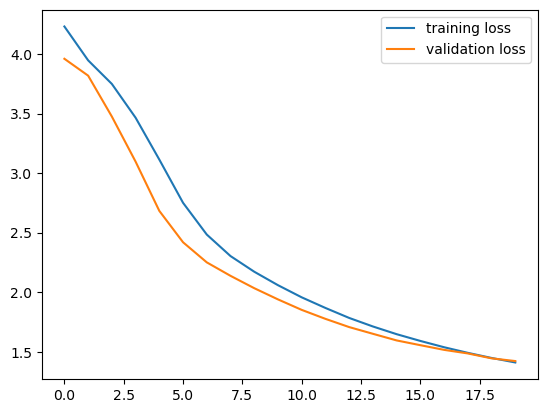

[Epoch  20/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 512.31it/s, train loss=tensor(1.4099), validation loss=tensor(1.4217)]


Train Loss: 1.409874439239502, Validation Loss: 1.4216976165771484


[Epoch  21/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.27it/s, train loss=tensor(1.3767), validation loss=tensor(1.3973)]


Train Loss: 1.376739263534546, Validation Loss: 1.3973065614700317


[Epoch  22/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.40it/s, train loss=tensor(1.3465), validation loss=tensor(1.3744)]


Train Loss: 1.3465020656585693, Validation Loss: 1.3743844032287598


[Epoch  23/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.00it/s, train loss=tensor(1.3137), validation loss=tensor(1.3465)]


Train Loss: 1.3137469291687012, Validation Loss: 1.3465361595153809


[Epoch  24/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.93it/s, train loss=tensor(1.2750), validation loss=tensor(1.3254)]


Train Loss: 1.2749931812286377, Validation Loss: 1.3254467248916626


[Epoch  25/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.03it/s, train loss=tensor(1.2385), validation loss=tensor(1.2860)]


Train Loss: 1.23847496509552, Validation Loss: 1.285986304283142


[Epoch  26/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.64it/s, train loss=tensor(1.2057), validation loss=tensor(1.2649)]


Train Loss: 1.2056865692138672, Validation Loss: 1.2648636102676392


[Epoch  27/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.09it/s, train loss=tensor(1.1748), validation loss=tensor(1.2396)]


Train Loss: 1.1747658252716064, Validation Loss: 1.239624261856079


[Epoch  28/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.81it/s, train loss=tensor(1.1479), validation loss=tensor(1.2149)]


Train Loss: 1.1479177474975586, Validation Loss: 1.2149158716201782


[Epoch  29/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.90it/s, train loss=tensor(1.1226), validation loss=tensor(1.2003)]


Train Loss: 1.122566819190979, Validation Loss: 1.2003227472305298


[Epoch  30/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 518.18it/s, train loss=tensor(1.0999), validation loss=tensor(1.1752)]


Train Loss: 1.0998589992523193, Validation Loss: 1.175203561782837


[Epoch  31/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.05it/s, train loss=tensor(1.0796), validation loss=tensor(1.1551)]


Train Loss: 1.0795769691467285, Validation Loss: 1.1550544500350952


[Epoch  32/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.65it/s, train loss=tensor(1.0607), validation loss=tensor(1.1412)]


Train Loss: 1.060684323310852, Validation Loss: 1.1412147283554077


[Epoch  33/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 522.19it/s, train loss=tensor(1.0440), validation loss=tensor(1.1273)]


Train Loss: 1.044020175933838, Validation Loss: 1.1273497343063354


[Epoch  34/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.62it/s, train loss=tensor(1.0292), validation loss=tensor(1.1165)]


Train Loss: 1.0292006731033325, Validation Loss: 1.1164978742599487


[Epoch  35/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.56it/s, train loss=tensor(1.0149), validation loss=tensor(1.1031)]


Train Loss: 1.0148662328720093, Validation Loss: 1.103075385093689


[Epoch  36/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.46it/s, train loss=tensor(1.0007), validation loss=tensor(1.0924)]


Train Loss: 1.0007140636444092, Validation Loss: 1.0924463272094727


[Epoch  37/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 518.22it/s, train loss=tensor(0.9892), validation loss=tensor(1.0830)]


Train Loss: 0.9891517162322998, Validation Loss: 1.083046793937683


[Epoch  38/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 515.08it/s, train loss=tensor(0.9775), validation loss=tensor(1.0720)]


Train Loss: 0.9775403738021851, Validation Loss: 1.071972131729126


[Epoch  39/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:18<00:00, 505.51it/s, train loss=tensor(0.9670), validation loss=tensor(1.0636)]


Train Loss: 0.9670094847679138, Validation Loss: 1.0635594129562378


[Epoch  40/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 569.87it/s, train loss=tensor(0.9578), validation loss=tensor(1.0542)]

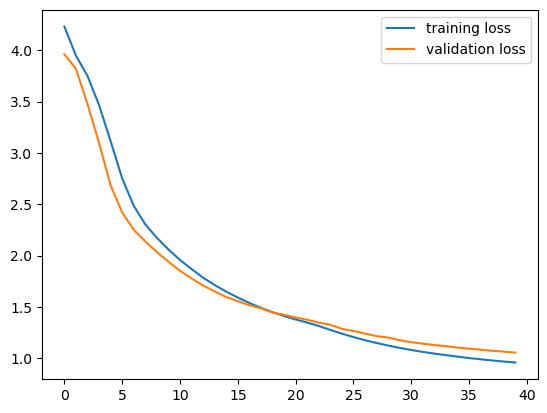

[Epoch  40/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.09it/s, train loss=tensor(0.9578), validation loss=tensor(1.0542)]


Train Loss: 0.9578117728233337, Validation Loss: 1.054213523864746


[Epoch  41/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.50it/s, train loss=tensor(0.9484), validation loss=tensor(1.0471)]


Train Loss: 0.9483919739723206, Validation Loss: 1.0471121072769165


[Epoch  42/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.91it/s, train loss=tensor(0.9392), validation loss=tensor(1.0380)]


Train Loss: 0.9392011761665344, Validation Loss: 1.0379908084869385


[Epoch  43/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.74it/s, train loss=tensor(0.9308), validation loss=tensor(1.0291)]


Train Loss: 0.9307616353034973, Validation Loss: 1.0290666818618774


[Epoch  44/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.76it/s, train loss=tensor(0.9228), validation loss=tensor(1.0220)]


Train Loss: 0.9227864742279053, Validation Loss: 1.0219733715057373


[Epoch  45/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.93it/s, train loss=tensor(0.9153), validation loss=tensor(1.0154)]


Train Loss: 0.9152836799621582, Validation Loss: 1.0154260396957397


[Epoch  46/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 515.27it/s, train loss=tensor(0.9088), validation loss=tensor(1.0097)]


Train Loss: 0.9088156223297119, Validation Loss: 1.009721040725708


[Epoch  47/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.90it/s, train loss=tensor(0.9017), validation loss=tensor(1.0031)]


Train Loss: 0.901703417301178, Validation Loss: 1.0031380653381348


[Epoch  48/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.70it/s, train loss=tensor(0.8955), validation loss=tensor(0.9966)]


Train Loss: 0.8955190777778625, Validation Loss: 0.9966176748275757


[Epoch  49/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.70it/s, train loss=tensor(0.8905), validation loss=tensor(0.9920)]


Train Loss: 0.8904951214790344, Validation Loss: 0.9919773936271667


[Epoch  50/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 519.30it/s, train loss=tensor(0.8845), validation loss=tensor(0.9885)]


Train Loss: 0.8845444917678833, Validation Loss: 0.9884762167930603


[Epoch  51/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.95it/s, train loss=tensor(0.8802), validation loss=tensor(0.9837)]


Train Loss: 0.8801949620246887, Validation Loss: 0.9837305545806885


[Epoch  52/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.95it/s, train loss=tensor(0.8754), validation loss=tensor(0.9813)]


Train Loss: 0.8754416704177856, Validation Loss: 0.9813202619552612


[Epoch  53/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.42it/s, train loss=tensor(0.8720), validation loss=tensor(0.9788)]


Train Loss: 0.8720439672470093, Validation Loss: 0.9787927269935608


[Epoch  54/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 522.02it/s, train loss=tensor(0.8671), validation loss=tensor(0.9747)]


Train Loss: 0.867119550704956, Validation Loss: 0.9746524095535278


[Epoch  55/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.44it/s, train loss=tensor(0.8635), validation loss=tensor(0.9713)]


Train Loss: 0.8634809851646423, Validation Loss: 0.9713127613067627


[Epoch  56/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.23it/s, train loss=tensor(0.8603), validation loss=tensor(0.9686)]


Train Loss: 0.8602749109268188, Validation Loss: 0.9685935378074646


[Epoch  57/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 522.24it/s, train loss=tensor(0.8565), validation loss=tensor(0.9687)]


Train Loss: 0.8564673066139221, Validation Loss: 0.9687489867210388


[Epoch  58/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.86it/s, train loss=tensor(0.8535), validation loss=tensor(0.9646)]


Train Loss: 0.8534930348396301, Validation Loss: 0.9646160006523132


[Epoch  59/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.93it/s, train loss=tensor(0.8500), validation loss=tensor(0.9611)]


Train Loss: 0.8499707579612732, Validation Loss: 0.9610800743103027


[Epoch  60/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 571.65it/s, train loss=tensor(0.8480), validation loss=tensor(0.9592)]

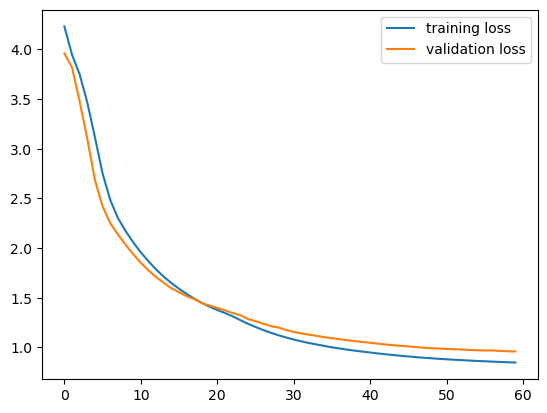

[Epoch  60/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.76it/s, train loss=tensor(0.8480), validation loss=tensor(0.9592)]


Train Loss: 0.8479673862457275, Validation Loss: 0.9591665267944336


[Epoch  61/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.85it/s, train loss=tensor(0.8449), validation loss=tensor(0.9585)]


Train Loss: 0.8448916673660278, Validation Loss: 0.9585309028625488


[Epoch  62/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.84it/s, train loss=tensor(0.8418), validation loss=tensor(0.9576)]


Train Loss: 0.8418460488319397, Validation Loss: 0.957587718963623


[Epoch  63/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 523.07it/s, train loss=tensor(0.8399), validation loss=tensor(0.9536)]


Train Loss: 0.8399189710617065, Validation Loss: 0.9536123275756836


[Epoch  64/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.85it/s, train loss=tensor(0.8379), validation loss=tensor(0.9527)]


Train Loss: 0.8378864526748657, Validation Loss: 0.9526792168617249


[Epoch  65/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.77it/s, train loss=tensor(0.8355), validation loss=tensor(0.9516)]


Train Loss: 0.835511326789856, Validation Loss: 0.9516017436981201


[Epoch  66/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.16it/s, train loss=tensor(0.8329), validation loss=tensor(0.9490)]


Train Loss: 0.8328894376754761, Validation Loss: 0.949026882648468


[Epoch  67/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 518.98it/s, train loss=tensor(0.8309), validation loss=tensor(0.9488)]


Train Loss: 0.8309075832366943, Validation Loss: 0.9488033056259155


[Epoch  68/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 518.29it/s, train loss=tensor(0.8292), validation loss=tensor(0.9488)]


Train Loss: 0.8291649222373962, Validation Loss: 0.9488179087638855


[Epoch  69/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 522.28it/s, train loss=tensor(0.8273), validation loss=tensor(0.9472)]


Train Loss: 0.8272961974143982, Validation Loss: 0.9471830129623413


[Epoch  70/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.18it/s, train loss=tensor(0.8257), validation loss=tensor(0.9435)]


Train Loss: 0.82569420337677, Validation Loss: 0.9435198903083801


[Epoch  71/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.05it/s, train loss=tensor(0.8238), validation loss=tensor(0.9426)]


Train Loss: 0.8237574100494385, Validation Loss: 0.9426472783088684


[Epoch  72/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.08it/s, train loss=tensor(0.8220), validation loss=tensor(0.9418)]


Train Loss: 0.8220362663269043, Validation Loss: 0.941783607006073


[Epoch  73/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 517.96it/s, train loss=tensor(0.8197), validation loss=tensor(0.9425)]


Train Loss: 0.819708526134491, Validation Loss: 0.9424834847450256


[Epoch  74/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 523.51it/s, train loss=tensor(0.8188), validation loss=tensor(0.9408)]


Train Loss: 0.8187621235847473, Validation Loss: 0.9408177137374878


[Epoch  75/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 523.18it/s, train loss=tensor(0.8170), validation loss=tensor(0.9374)]


Train Loss: 0.8169882297515869, Validation Loss: 0.9373641610145569


[Epoch  76/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.53it/s, train loss=tensor(0.8150), validation loss=tensor(0.9385)]


Train Loss: 0.8149973154067993, Validation Loss: 0.9385151863098145


[Epoch  77/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.53it/s, train loss=tensor(0.8137), validation loss=tensor(0.9376)]


Train Loss: 0.813712477684021, Validation Loss: 0.937636137008667


[Epoch  78/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.60it/s, train loss=tensor(0.8133), validation loss=tensor(0.9379)]


Train Loss: 0.8132614493370056, Validation Loss: 0.9379324316978455


[Epoch  79/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 523.29it/s, train loss=tensor(0.8113), validation loss=tensor(0.9351)]


Train Loss: 0.8113101124763489, Validation Loss: 0.9351266026496887


[Epoch  80/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 574.36it/s, train loss=tensor(0.8090), validation loss=tensor(0.9367)]

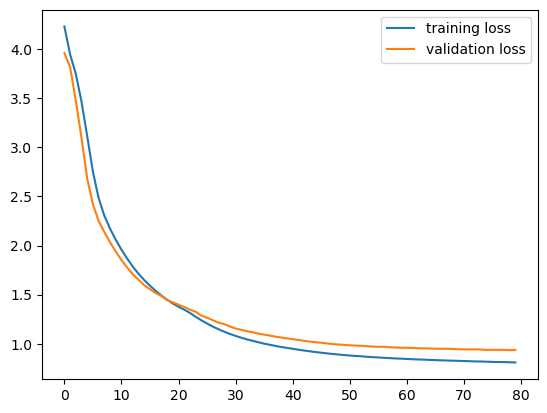

[Epoch  80/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.75it/s, train loss=tensor(0.8090), validation loss=tensor(0.9367)]


Train Loss: 0.8090212941169739, Validation Loss: 0.9366561770439148


[Epoch  81/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.70it/s, train loss=tensor(0.8085), validation loss=tensor(0.9330)]


Train Loss: 0.8084709048271179, Validation Loss: 0.9330175518989563


[Epoch  82/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.62it/s, train loss=tensor(0.8080), validation loss=tensor(0.9319)]


Train Loss: 0.8079617023468018, Validation Loss: 0.9318552613258362


[Epoch  83/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.45it/s, train loss=tensor(0.8061), validation loss=tensor(0.9328)]


Train Loss: 0.8061125874519348, Validation Loss: 0.9327766299247742


[Epoch  84/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.41it/s, train loss=tensor(0.8048), validation loss=tensor(0.9320)]


Train Loss: 0.8048369288444519, Validation Loss: 0.9320365190505981


[Epoch  85/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.07it/s, train loss=tensor(0.8037), validation loss=tensor(0.9302)]


Train Loss: 0.8037222027778625, Validation Loss: 0.930221676826477


[Epoch  86/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.77it/s, train loss=tensor(0.8032), validation loss=tensor(0.9306)]


Train Loss: 0.8031870126724243, Validation Loss: 0.93060302734375


[Epoch  87/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.13it/s, train loss=tensor(0.8021), validation loss=tensor(0.9298)]


Train Loss: 0.8021340370178223, Validation Loss: 0.9298021793365479


[Epoch  88/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.44it/s, train loss=tensor(0.8002), validation loss=tensor(0.9292)]


Train Loss: 0.8001753091812134, Validation Loss: 0.9292214512825012


[Epoch  89/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.00it/s, train loss=tensor(0.7994), validation loss=tensor(0.9288)]


Train Loss: 0.7994441390037537, Validation Loss: 0.9287647008895874


[Epoch  90/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.50it/s, train loss=tensor(0.7987), validation loss=tensor(0.9279)]


Train Loss: 0.7986616492271423, Validation Loss: 0.9279215335845947


[Epoch  91/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.34it/s, train loss=tensor(0.7977), validation loss=tensor(0.9264)]


Train Loss: 0.7977452278137207, Validation Loss: 0.9263752698898315


[Epoch  92/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.01it/s, train loss=tensor(0.7970), validation loss=tensor(0.9261)]


Train Loss: 0.7970096468925476, Validation Loss: 0.926093578338623


[Epoch  93/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 520.00it/s, train loss=tensor(0.7956), validation loss=tensor(0.9266)]


Train Loss: 0.7955848574638367, Validation Loss: 0.9265801906585693


[Epoch  94/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 522.91it/s, train loss=tensor(0.7947), validation loss=tensor(0.9258)]


Train Loss: 0.7947046756744385, Validation Loss: 0.9257639646530151


[Epoch  95/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:13<00:00, 523.00it/s, train loss=tensor(0.7946), validation loss=tensor(0.9259)]


Train Loss: 0.7945759892463684, Validation Loss: 0.9259480834007263


[Epoch  96/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:14<00:00, 521.62it/s, train loss=tensor(0.7942), validation loss=tensor(0.9257)]


Train Loss: 0.7941589951515198, Validation Loss: 0.9256806969642639


[Epoch  97/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 518.32it/s, train loss=tensor(0.7928), validation loss=tensor(0.9231)]


Train Loss: 0.7928397059440613, Validation Loss: 0.9231110215187073


[Epoch  98/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.08it/s, train loss=tensor(0.7922), validation loss=tensor(0.9257)]


Train Loss: 0.7921706438064575, Validation Loss: 0.9256812334060669


[Epoch  99/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 516.30it/s, train loss=tensor(0.7906), validation loss=tensor(0.9243)]


Train Loss: 0.7906278371810913, Validation Loss: 0.9242868423461914


[Epoch 100/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:15<00:00, 560.43it/s, train loss=tensor(0.7907), validation loss=tensor(0.9233)]

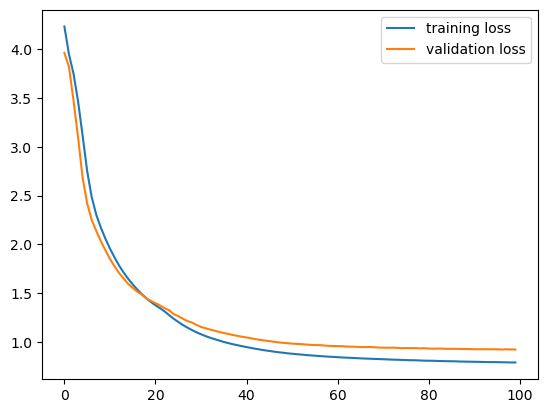

[Epoch 100/100]: 100%|████████████████████████████████████████████████████| 69986/69986 [02:16<00:00, 513.29it/s, train loss=tensor(0.7907), validation loss=tensor(0.9233)]

Train Loss: 0.790733277797699, Validation Loss: 0.9233090877532959


In [62]:
cur_step=1
train_loss_arr = []
val_loss_arr = []
for epoch_idx in range(config['EPOCHS']):
    with tqdm(total=len(train_dl.dataset), desc=f"[Epoch {epoch_idx+1:3d}/{config['EPOCHS']}]") as pbar:
        # Train
        train_loss=0
        model.train()
        for batch_idx, batch in enumerate(train_dl):
            xb,yb=batch
            xb,yb =xb.to(device),yb.to(device)
            preds=model(xb,yb) # (batch_size, seq_len, vocab_size)

            loss=loss_func(
                preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                yb[:, 1:].contiguous().view(-1) # Shifting right (without BOS)
            )
            train_loss+=loss.detach().cpu()


            loss.backward()
            if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            cur_step+=1
                
            pbar.set_postfix({'running loss': train_loss/(batch_idx+1)})
            pbar.update(xb.shape[0])

        # Validation
        val_loss=0
        with torch.no_grad():
            model.eval() # to ignore dropout layers
            for batch_idx, batch in enumerate(val_dl):
                xb,yb=batch
                xb,yb =xb.to(device),yb.to(device)
                preds=model(xb,yb)

                loss=loss_func(
                    preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                    yb[:, 1:].contiguous().view(-1) # Shifting right (without BOS)
                )
                val_loss+=loss.detach().cpu()
        
        train_loss = train_loss / len(train_dl)
        val_loss = val_loss / len(val_dl)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        pbar.set_postfix({'train loss': train_loss, 'validation loss': val_loss})
                
        # save model every 20 epochs
        if (epoch_idx+1) % 20 == 0:
            model_save_path = f'models/astar_473_3blocks_epoch{epoch_idx+1}_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pt'
            torch.save(model.state_dict(), model_save_path)
            torch.save({
                'epoch': (epoch_idx+1),
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss_arr': train_loss_arr,
                'val_loss_arr': val_loss_arr,
                }, model_save_path)
            plt.plot(train_loss_arr, label="training loss")
            plt.plot(val_loss_arr, label="validation loss")
            plt.legend()
            plt.show()
            
    print(f"Train Loss: {train_loss}, Validation Loss: {val_loss}")

In [30]:
path = f'models/test.pt'
idx = 10
torch.save({
    'epoch': idx+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, path)

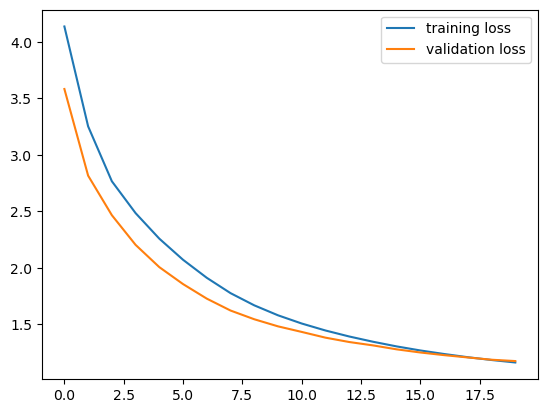

In [30]:
model_save_path = f'models/gcc_403_3blocks_epoch{epoch_idx+1}_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pt'
torch.save(model.state_dict(), model_save_path)
torch.save({
    'epoch': (epoch_idx+1),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_arr': train_loss_arr,
    'val_loss_arr': val_loss_arr,
    }, model_save_path)
plt.plot(train_loss_arr, label="training loss")
plt.plot(val_loss_arr, label="validation loss")
plt.legend()
plt.show()

### Train from Checkpoint

In [31]:
epoch

60

In [33]:
load_path = 'models/fixedShiftRight_checkpoint_2022_11_08__234630.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_arr = checkpoint['train_loss_arr']
val_loss_arr = checkpoint['val_loss_arr']

cur_step = 1
for epoch_idx in range(config['EPOCHS']):
    
    # skip the trained epochs
    if epoch_idx <= epoch:
        for _ in range(len(train_dl)):
            cur_step += 1
            if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
                scheduler.step()
        continue
        
    with tqdm(total=len(train_dl.dataset), desc=f"[Epoch {epoch_idx+1:3d}/{config['EPOCHS']}]") as pbar:
        # Train
        train_loss=0
        model.train()
        for batch_idx, batch in enumerate(train_dl):
            xb,yb=batch
            xb,yb =xb.to(device),yb.to(device)
            preds=model(xb,yb) # (batch_size, seq_len, vocab_size)

            loss=loss_func(
                preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                yb[:, 1:].contiguous().view(-1) # Shifting right (without BOS)
            )
            train_loss+=loss.detach().cpu()


            loss.backward()
            if cur_step % config['GRAD_ACCUMULATION_STEPS']==0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            cur_step+=1
                
            pbar.set_postfix({'running loss': train_loss/(batch_idx+1)})
            pbar.update(xb.shape[0])

        # Validation
        val_loss=0
        with torch.no_grad():
            model.eval() # to ignore dropout layers
            for batch_idx, batch in enumerate(val_dl):
                xb,yb=batch
                xb,yb =xb.to(device),yb.to(device)
                preds=model(xb,yb)

                loss=loss_func(
                    preds.reshape(-1, preds.size(-1)), # Reshaping for loss
                    yb[:, 1:].contiguous().view(-1) # Shifting right (without BOS)
                )
                val_loss+=loss.detach().cpu()
        
        train_loss = train_loss / len(train_dl)
        val_loss = val_loss / len(val_dl)
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        pbar.set_postfix({'train loss': train_loss, 'validation loss': val_loss})
                
        # save model every 20 epochs
        if (epoch_idx+1) % 20 == 0:
            model_save_path = f'models/fixedShiftRight_epoch{epoch_idx}_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
            torch.save(model.state_dict(), model_save_path)

[Epoch 100/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57427/57427 [01:50<00:00, 519.51it/s, train loss=tensor(0.7797), validation loss=tensor(0.8026)]


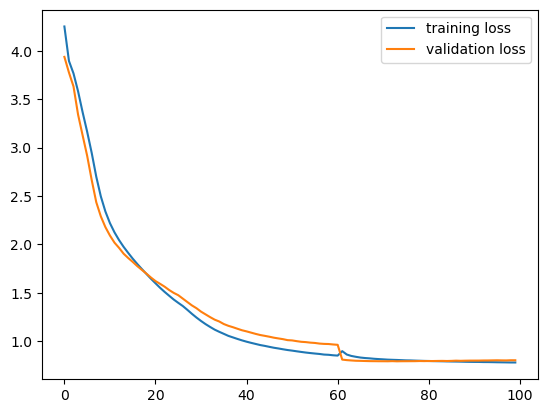

In [34]:
# train 2
plt.plot(train_loss_arr, label="training loss")
plt.plot(val_loss_arr, label="validation loss")
plt.legend()
plt.show()

In [35]:
path = f'models/fixedShiftRight_checkpoint_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pt'
torch.save({
    'epoch': 100,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_arr': train_loss_arr,
    'val_loss_arr': val_loss_arr,
    }, path)

## Test Accuracy

In [41]:
load_path = 'models/gcc_403_3blocks_epoch100_2022_12_02__010717.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
train_loss_arr = checkpoint['train_loss_arr']
val_loss_arr = checkpoint['val_loss_arr']

In [33]:
torch.save(model.state_dict(), 'models/gcc_403_3blocks_latest.pth')

In [63]:
pth = torch.load('models/useDataCollectedByMe_latest.pth')
model.load_state_dict(pth)

<All keys matched successfully>

In [64]:
def translate(model: nn.Module, sentence):
    
    model.eval()
    # Infer the device of the model
    device = next(model.parameters()).device

    # sanity check
    if len(sentence) != (config['INPUT_ADDR_NUM']+1) * config['ADDR_CHUNKS']:
        print(f"You should provide {config['INPUT_ADDR_NUM']+1} addresses in a row as input.\n")

    # Initialize target sequence with SOS token.
    src_token_ids = sentence[:(-config['ADDR_CHUNKS'])].unsqueeze(0).to(device) # (1, INPUT_ADDR_NUM * ADDR_CHUNKS)
    trg_token_ids = sentence[(-config['ADDR_CHUNKS']):].unsqueeze(0).to(device) # (1, 1 * ADDR_CHUNKS)

    # Obtain src mask
    # src_mask=model._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

    # with torch.no_grad():
    encoder_output=model.transformer_encoder_decoder.encode(src_token_ids, src_mask=None) # (batch_size, src_seq_len, d_model)

    for _ in range((config['OUTPUT_ADDR_NUM']-1) * config['ADDR_CHUNKS']):

        # Obtain decoder output.
        trg_mask=model._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
        decoder_output=model.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask=None, trg_mask=trg_mask)

        # Identify token with highest probability.
        softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
        softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
        _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

        # Check if token is EOS or we reached the maximum number of tokens.
        # if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
        #     trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
        #     break

        # Add token to target sequence.
        trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

    # Detokenize sentence.
    # decoded_output=tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

    return trg_token_ids

**Prediction of the next after next address:**

In [75]:
correct = 0
for xt, yt in test_ds:
    sentence = torch.cat([xt[:], yt[:5]]).to(device)
    pred = translate(model, sentence).squeeze(0).cpu()
    truth = yt[15:20]
    # print('pred: ', pred)
    # print('truth: ', truth)
    if torch.all(torch.eq(pred[15:20], truth)):
        correct += 1

print(f"accuracy ({correct}/{len(test_ds)}): ", correct / len(test_ds))

accuracy (11716/16827):  0.6962619599453259


**Prediction of next address:**

In [74]:
correct = 0
for xt, yt in tqdm(test_ds):
    sentence = torch.cat([xt[:], yt[:5]]).to(device)
    pred = translate(model, sentence).squeeze(0).cpu()
    truth = yt[5:10]
    # print('pred: ', pred)
    # print('truth: ', truth)
    if torch.all(torch.eq(pred[5:10], truth)):
        correct += 1

print(f"accuracy ({correct}/{len(test_ds)}): ", correct / len(test_ds))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16827/16827 [16:40<00:00, 16.82it/s]

accuracy (13238/16827):  0.7867118321744815


## Other tests

In [81]:
def tensor2address(sequence):
    sequence = sequence.squeeze(0).tolist()
    addrs = []
    for i in range(4):
        addr = 0
        for j in range(4, -1, -1):
            addr |= sequence[5*i+j]
            addr <<= 6
        addrs.append(addr)
    return addrs
    
def split_address(addr):
    split_addr = []
    addr = addr >> 6
    for i in range(5): # try ADDR_CHUNKS=5 to eliminate the zeros
        split_addr.append(addr & 0x3F)
        addr = addr >> 6
    return split_addr
        

def address2tensor(addrs): # array of 17 addresses

    sentence = []
    for i in range(17):
        sentence.extend(split_address(addrs[i]))

    return torch.tensor(sentence)

In [93]:
def translate2(model: nn.Module, sentence):
    
    model.eval()
    # Infer the device of the model
    device = next(model.parameters()).device

    # sanity check
    if len(sentence) != (config['INPUT_ADDR_NUM']+1):
        print(f"You should provide {config['INPUT_ADDR_NUM']+1} addresses in a row as input.\n")

    # Initialize target sequence with SOS token.
    sentence = address2tensor(sentence)
    src_token_ids = sentence[:(-config['ADDR_CHUNKS'])].unsqueeze(0).to(device) # (1, INPUT_ADDR_NUM * ADDR_CHUNKS)
    trg_token_ids = sentence[(-config['ADDR_CHUNKS']):].unsqueeze(0).to(device) # (1, 1 * ADDR_CHUNKS)

    # Obtain src mask
    # src_mask=model._get_pad_mask(src_token_ids) # (batch_size, src_seq_len)

    # with torch.no_grad():
    encoder_output=model.transformer_encoder_decoder.encode(src_token_ids, src_mask=None) # (batch_size, src_seq_len, d_model)

    for _ in range((config['OUTPUT_ADDR_NUM']-1) * config['ADDR_CHUNKS']):

        # Obtain decoder output.
        trg_mask=model._get_lookahead_mask(trg_token_ids)  # Can also be set to None but for my config I found this works better.
        decoder_output=model.transformer_encoder_decoder.decode(trg_token_ids, encoder_output, src_mask=None, trg_mask=trg_mask)

        # Identify token with highest probability.
        softmax_output=nn.functional.log_softmax(decoder_output, dim=-1) # (batch_size, trg_seq_len, trg_vocab_size)
        softmax_output_last=softmax_output[:, -1, :] # (batch_size, trg_vocab_size)
        _, token_id=softmax_output_last.max(dim=-1) # (batch_size, trg_seq_len)

        # Check if token is EOS or we reached the maximum number of tokens.
        # if token_id.item() == eos_id or trg_token_ids.size(1) == max_tokens:
        #     trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)
        #     break

        # Add token to target sequence.
        trg_token_ids=torch.cat([trg_token_ids, token_id.unsqueeze(0)], dim=-1) # (batch_size, trg_seq_len+1)

    # Detokenize sentence.
    # decoded_output=tokenizer.decode(trg_token_ids.squeeze(0).detach().cpu().numpy(), skip_special_tokens=skip_special_tokens)

    return tensor2address(trg_token_ids)

In [83]:
test_input = data['addr'][:17]
truth_output = data['addr'][17:21]
print(test_input)
print(truth_output)

[6705970816, 6705970880, 6705968896, 6705968512, 6705968576, 6705968640, 1684653952, 1684654016, 5840117248, 6705968960, 6705970688, 6705970752, 5210693696, 7625493888, 5210694400, 4643160832, 4643160896]
[7468720832, 7468720320, 5471505920, 5471505664]


In [94]:
translate2(model, test_input)

[4643160896, 7468720832, 7468720320, 5471505920]

In [136]:
test_input = '1743895872,1743895936,7003590912,6985208192,6109025280,6109025408,6109025472,2633967296,2633967360,5517112704,2633967488,5517112640,2633967552,2633967424,6109024512,6109024576,6109024640'
test_input = [int(x) for x in test_input.split(',')]
print(test_input)
translate2(model, test_input)

[1743895872, 1743895936, 7003590912, 6985208192, 6109025280, 6109025408, 6109025472, 2633967296, 2633967360, 5517112704, 2633967488, 5517112640, 2633967552, 2633967424, 6109024512, 6109024576, 6109024640]


[6109024640, 6113563200, 3120986176, 3120986112]

In [148]:
6109024448 in data['addr']

False

In [138]:
numFalse = 0
for addr in test_input:
    if addr not in data['addr']:
        numFalse += 1
print(numFalse)

17


In [144]:
data['addr'][20000]

4124726208